In [3]:
cd ~/Documents/AGEL/Data

/Users/rodrigoc/Documents/AGEL/Data


In [7]:
import numpy as np
from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table, vstack, join
from astropy.convolution import convolve, Gaussian1DKernel
import sys
from scipy.interpolate import interp1d
from scipy.ndimage import median_filter
from scipy.stats import binned_statistic
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.linear_model import LinearRegression


import fitsio

import os
import urllib.request

from tqdm import tqdm
from glob import glob
from scipy import interpolate

from scipy.special import erf

import desispec.io

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from scipy.optimize import curve_fit



/Users/rodrigoc/Documents/Princeton/HSC+DESI/desitarget/py/desitarget/targetmask.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [28]:
topdir = 'DESI_DR1_spectra/'  #-- local directory to store the downloaded spectra

def get_spec_data_DR1(tid, fujidata = None, survey=None, program=None, zs = False):
    #-- the index of the specific target can be uniquely determined with the combination of TARGETID, SURVEY, and PROGRAM
    idx = np.where( (fujidata["TARGETID"]==tid) & (fujidata["SURVEY"]==survey) & (fujidata["PROGRAM"]==program) )[0][0]

    #-- healpix values are integers but are converted here into a string for easier access to the file path
    hpx = fujidata["HEALPIX"].astype(str)

    specprod = "iron"
    
    specprod_dir = f"https://data.desi.lbl.gov/public/dr1/spectro/redux/{specprod}"
    target_dir   = f"{specprod_dir}/healpix/{survey}/{program}/{hpx[idx][:-2]}/{hpx[idx]}"
    coadd_fname  = f"coadd-{survey}-{program}-{hpx[idx]}.fits"
    rr_fname  = f"redrock-{survey}-{program}-{hpx[idx]}.fits"
    
    dirname = f"{topdir}/{survey}/{program}/{hpx[idx]}/"
    flocal = f"{topdir}/{survey}/{program}/{hpx[idx]}/{coadd_fname}"
    flocal2 = f"{topdir}/{survey}/{program}/{hpx[idx]}/{rr_fname}"
    
    url = f"{target_dir}/{coadd_fname}"
    url2 = f"{target_dir}/{rr_fname}"

    if not os.path.isfile(flocal2):
        os.makedirs(dirname, exist_ok=True)
        
        if not os.path.isfile(flocal):
            print(f"downloading {url}")
            urllib.request.urlretrieve(url, flocal)
        
        if not os.path.isfile(flocal2):
            print(f"downloading {url2}")
            urllib.request.urlretrieve(url2, flocal2)

    #-- read in the spectra with desispec
    coadd_obj  = desispec.io.read_spectra(f"{flocal}")
    coadd_tgts = coadd_obj.target_ids().data

    #-- select the spectrum of  targetid
    row = ( coadd_tgts==fujidata["TARGETID"][idx] )
    coadd_spec = coadd_obj[row]

    if zs == True:
            rr = fits.open(flocal2)

            z = rr[1].data['Z'][idx].astype(np.float32)
            zerr = rr[1].data['ZERR'][idx].astype(np.float32)

            return coadd_spec, [z, zerr]
    
    return coadd_spec




def _redshift(data_in, z_in, z_out, data_type):
    """Redshift Correction for input data

    Parameters
    ----------
    data_in : numpy.ndarray
        Input data which is either flux values, wavelengths or ivars.
        Default DESI units are assumed.
    z_in : float or numpy.ndarray
        input redshifts
    z_out : float or numpy.ndarray
        output redshifts
    data_type : str
        "flux", "wave" or "ivar"

    Returns
    -------
    numpy.ndarray
        redshift corrected value corresponding to data type
    """
    exponent_dict = {"flux": -1, "wave": 1, "ivar": 2}
    assert data_type in exponent_dict.keys(), "Not a valid Data Type"
    data_in = np.atleast_2d(data_in)

    if z_in.ndim == 1:
        z_in = z_in[:, np.newaxis]
    exponent = exponent_dict[data_type]
    data_out = data_in * (((1 + z_out) / (1 + z_in)) ** exponent)

    return data_out


def _common_grid(flux, wave, ivar, z_in, z_out=0.0, wave_grid=None):
    """Bring spectra to a common grid

    Parameters
    ----------
    flux : np.ndarray
        numpy array containing the flux grid of shape [num_spectra, num_wavelengths]
    wave : np.ndarray
        numpy array containing the wavelength grid of shape [num_wavelengths] or [num_spectra, num_wavelengths]
    ivar : np.ndarray
        numpy array containing the inverse variance grid of shape [num_spectra, num_wavelengths]
    z_in : np.ndarray
        a 1D numpy array containing the redshifts of each spectra
    z_out : float, optional
        common redshift for the output data, by default 0.0
    wave_grid : np.ndarray, optional
        a 1D vector containing the wavelength grid for the output, by default None.
        If set to None, the wavelength grid is linearly spaced between the maximum and minimum
        possible wavelengths after redshift correction with a bin width of 0.8 Angstrom (DESI default)

    Returns
    -------
    flux_new: np.ndarray
        All the input fluxes brought to a common redshift and wavelength grid.
        Missing values and extrapolations are denoted with nan.
    ivar_new: np.ndarray
        All input inverse variances brought to a common redshift and wavelength grid.
        Missing values and extrapolations are denoted with nan.
    wave_grid: np.ndarray
        The common wavelength grid.
    """
    # Correct for redshift
    z_out = np.atleast_1d(z_out)
    flux_new = _redshift(flux, z_in, z_out, "flux")
    wave_new = _redshift(wave, z_in, z_out, "wave")
    ivar_new = _redshift(ivar, z_in, z_out, "ivar")
    # TODO Fix the resolution issue
    # resample to common grid
    if wave_grid is None:
        wave_grid = np.arange(np.min(wave_new), np.max(wave_new), 0.32)
    flux_new, ivar_new = resample_spectra(
        wave_grid, wave_new, flux_new, ivar_new, verbose=False, fill=np.nan
    )
    return flux_new, ivar_new, wave_grid


def _coadd_cameras(flux_cam, wave_cam, ivar_cam):
    """Adds spectra from the three cameras to give on combined spectra per object

    Parameters
    ----------
    flux_cam : dict
        Dictionary containing the flux values from the three cameras
    wave_cam : dict
        Dictionary containing the wavelength values from the three cameras
    ivar_cam : dict
        Dictionary containing the inverse variance values from the three cameras

    Returns
    -------
    Tuple
        returns the combined flux, wavelength and inverse variance grids.
    """
    # check_alignement_of_camera_wavelength(spectra)

    # ordering
    bands = list(wave_cam.keys())
    mwave = [np.mean(wave_cam[b]) for b in bands]
    sbands = np.array(bands)[np.argsort(mwave)]  # bands sorted by inc. wavelength

    # create wavelength array
    wave = None
    tolerance = 0.0001  # A , tolerance
    for b in sbands:
        if wave is None:
            wave = wave_cam[b]
        else:
            wave = np.append(wave, wave_cam[b][wave_cam[b] > wave[-1] + tolerance])
    nwave = wave.size

    # check alignment
    number_of_overlapping_cameras = np.zeros(nwave)
    for b in bands:
        windices = np.argmin(
            (
                np.tile(wave, (wave_cam[b].size, 1))
                - np.tile(wave_cam[b], (wave.size, 1)).T
            )
            ** 2,
            axis=1,
        )
        dist = np.sqrt(np.max(wave_cam[b] - wave[windices]))

        if dist > tolerance:
            print(
                "Cannot directly coadd the camera spectra because wavelength are not aligned,use --lin-step or --log10-step to resample to a common grid"
            )
            sys.exit(12)
        number_of_overlapping_cameras[windices] += 1
    # targets
    # TODO Add assertions to check all the input sizes are correct

    b = sbands[0]
    ntarget = len(flux_cam[b])
    flux = np.zeros((ntarget, nwave), dtype=flux_cam[b].dtype)
    ivar = np.zeros((ntarget, nwave), dtype=flux_cam[b].dtype)

    for b in bands:

        # indices
        windices = np.argmin(
            (
                np.tile(wave, (wave_cam[b].size, 1))
                - np.tile(wave_cam[b], (wave.size, 1)).T
            )
            ** 2,
            axis=1,
        )

        for i in range(ntarget):
            ivar[i, windices] += ivar_cam[b][i]
            flux[i, windices] += ivar_cam[b][i] * flux_cam[b][i]

    for i in range(ntarget):
        ok = ivar[i] > 0
        if np.sum(ok) > 0:
            flux[i][ok] /= ivar[i][ok]

    return flux, wave, ivar


def _normalize(flux, ivar):
    """
    A simple normalization to median=1 for flux
    Also adjusts inverse variance accordingly

    Parameters
    ----------
    flux: np.ndarray
        numpy array containing the flux grid of shape [num_spectra, num_wavelengths]

    ivar : np.ndarray
        numpy array containing the inverse variance grid of shape [num_spectra, num_wavelengths]

    Returns
    -------
    flux: np.ndarray
        flux that has been normalized to median one

    ivar: np.ndarray
        inverse variance that has been multipled by the normalization factor
        for the flux,squared

    """

    norm = np.nanmedian(flux, axis=1, keepdims=True)
    flux = flux / norm
    ivar = ivar * norm ** 2

    return flux, ivar


def _wavg(flux, ivar=None, weighted=False, weights=None):
    """
    Weighted average of the spectra.

    Parameters
    ----------
    flux: np.ndarray
        numpy array containing the flux grid of shape [num_spectra, num_wavelengths]

    ivar : np.ndarray
        numpy array containing the inverse variance grid of shape [num_spectra, num_wavelengths]

    weights : np.ndarray
        numpy array containing the weights grid of shape [num_spectra, num_wavelengths]

    weighted: True or False
        if false, use weight=1 for all the spectra
        else, perform a weighted average using the input for 'weights'

    Returns
    ----------
    avg: np.ndarray
        numpy array containing the averaged flux of shape [num_wavelengths]

    """

    if weighted:
        num = np.nansum(flux * weights, axis=0)
        denom = np.nansum(weights, axis=0)

        if 0.0 in denom:
            denom[denom == 0.0] = np.nan

        avg = np.nan_to_num(num / denom)
    else:
        avg = np.mean(flux, axis=0)

    ivar = np.nansum(ivar, axis=0)

    return avg, ivar


def _bootstrap(flux_spec, ndata, nbootstraps, len_spec):
    """
    Sample the spectra

    Parameters
    ----------
    flux_spec:  np.ndarray
        Numpy array containing the flux grid of shape [num_spectra, num_wavelengths]
        To avoid redundant calculations, this array can be the normalized spectra already
        brought to the common grid

    ndata: int
        The number of spectra to sample from

    nbootstraps: int
        The number of times to sample the data

    nsamples: int
        The number of bootstraps to do

    len_spec: int
        The number of wavelengths in the spectra

    Returns
    ----------
    stacks: np.ndarray
        numpy array containing the stacked spectra from the bootstraps of size [nsamples, len_spec]

    ivar: np.ndarray
        numpy array of size [len_spec] containing the inverse variance calculated from all the stacks

    """

    boot = np.zeros((nbootstraps, len_spec))
    for i in range(nbootstraps):
        idx = np.random.choice(ndata, 1, replace=True)
        boot[i] += flux_spec[idx][0]

    return boot


def stack_spectra(flux, wave, ivar, sky=None, bootstrap=False):
    """
    If flux/wave.ivar are dicts, coadd cameras.
    If sky is present model ivar and do modelled ivar weighted avg
    """

    stacks = np.zeros((nbootstraps, len_spec))
    for j in range(nbootstraps):
        boot = np.zeros((nsamples, len_spec))
        for i in range(nsamples):
            idx = np.random.choice(ndata, 1, replace=True)
            boot[i] += flux_spec[idx][0]
        stacks[j] += wavg(boot)

    ivar = 1.0 / (np.nanstd(stacks, axis=0)) ** 2

    return stacks, ivar


def model_ivar(ivar, sky_ivar, wave):
    n_obj = len(sky_ivar)
    sky_var = 1 / sky_ivar

    ivar_model = np.zeros_like(ivar)

    for i in range(n_obj):
        sky_mask = np.isfinite(sky_var[i])
        sky_var_interp = interp1d(
            wave[sky_mask], sky_var[i][sky_mask], fill_value="extrapolate", axis=-1
        )
        sky_var[i] = sky_var_interp(wave)
        sky_var[i] = sky_var[i] / median_filter(
            sky_var[i], 100
        )  # takes out the overall shape of sky var

        # Create polunomial function of wavelength
        poly_feat_m = PolynomialFeatures(3)
        poly_feat_c = PolynomialFeatures(3)
        coef_m = poly_feat_m.fit_transform(wave[:, np.newaxis])
        coef_c = poly_feat_c.fit_transform(wave[:, np.newaxis])

        obj_var = 1 / (ivar[i])
        obj_mask = np.isfinite(obj_var)  # TODO Check for Nan values here
        obj_back = median_filter(obj_var[obj_mask], 100, mode="nearest")
        X = (
            np.concatenate(
                [(coef_m * sky_var[i][:, np.newaxis])[obj_mask], coef_c[obj_mask]],
                axis=1,
            )
            + obj_back[:, np.newaxis]
        )
        Y = obj_var[obj_mask]
        model = LinearRegression(fit_intercept=False, n_jobs=-1)
        model.fit(X, Y)
        y_predict = model.predict(X)
        residual = (Y - y_predict) / Y
        # correct for the overall shape of the residuals
        wave_bins = np.arange(wave.min(), wave.max(), 500)
        binned_residual, _, _ = binned_statistic(
            wave[obj_mask], residual, statistic="median", bins=wave_bins
        )
        interp_binned_res = interp1d(
            (wave_bins[1:] + wave_bins[:-1]) / 2,
            binned_residual,
            kind="cubic",
            fill_value="extrapolate",
        )
        large_res = interp_binned_res(wave[obj_mask])
        y_pred_adjust = large_res * Y + y_predict
        ivar_model[i][obj_mask] = 1 / y_pred_adjust
        ivar_model[i][~obj_mask] = 0
    return ivar_model





def combine_spec_arms_ivar(coadd_spec):

    flux, wave, ivar = _coadd_cameras(coadd_spec.flux, coadd_spec.wave, coadd_spec.ivar)
    #print('Coadding cameras')
    return wave,flux[0], ivar[0]



In [29]:
DESI_AGEL_match = Table.read('/Users/rodrigoc/Documents/AGEL/Data/DESI_DR1_match_0pt5_arcsec_Spectral_Observations_Tally-Everything-including-non-lenses.fits')

In [ ]:
table = DESI_AGEL_match
for idx, ID in enumerate(DESI_AGEL_match['TARGETID'][0:10]):

    row = table[table['TARGETID'] == ID]
    coadd_spec = get_spec_data_DR1(ID, fujidata = table, survey= row['SURVEY'][0], program=row['PROGRAM'][0])
    lam, flux, ivar = combine_spec_arms_ivar(coadd_spec)
    err = 1 / np.sqrt(ivar)  # 1 sigma error

    plt.figure(idx, figsize=(12,6))
    plt.plot(lam, flux, color='black', lw=0.5)



INFO:spectra.py:391:read_spectra: iotime 0.803 sec to read coadd-main-bright-12391.fits at 2025-08-26T14:28:57.658240


/var/folders/5_/wvcj5nvd1hq5fwhbrwv87syw0000gn/T/ipykernel_51031/2772764443.py:7: RuntimeWarning: divide by zero encountered in divide
  err = 1 / np.sqrt(ivar)  # 1 sigma error


downloading https://data.desi.lbl.gov/public/dr1/spectro/redux/iron/healpix/main/bright/134/13409/coadd-main-bright-13409.fits
downloading https://data.desi.lbl.gov/public/dr1/spectro/redux/iron/healpix/main/bright/134/13409/redrock-main-bright-13409.fits
INFO:spectra.py:391:read_spectra: iotime 1.651 sec to read coadd-main-bright-13409.fits at 2025-08-26T14:31:53.823762
downloading https://data.desi.lbl.gov/public/dr1/spectro/redux/iron/healpix/main/bright/176/17622/coadd-main-bright-17622.fits
downloading https://data.desi.lbl.gov/public/dr1/spectro/redux/iron/healpix/main/bright/176/17622/redrock-main-bright-17622.fits
INFO:spectra.py:391:read_spectra: iotime 0.506 sec to read coadd-main-bright-17622.fits at 2025-08-26T14:32:20.022525
downloading https://data.desi.lbl.gov/public/dr1/spectro/redux/iron/healpix/main/bright/177/17730/coadd-main-bright-17730.fits
downloading https://data.desi.lbl.gov/public/dr1/spectro/redux/iron/healpix/main/bright/177/17730/redrock-main-bright-17730.f

/var/folders/5_/wvcj5nvd1hq5fwhbrwv87syw0000gn/T/ipykernel_51031/2433942835.py:2: RuntimeWarning: divide by zero encountered in divide
  err = 1 / np.sqrt(ivar)  # 1 sigma error


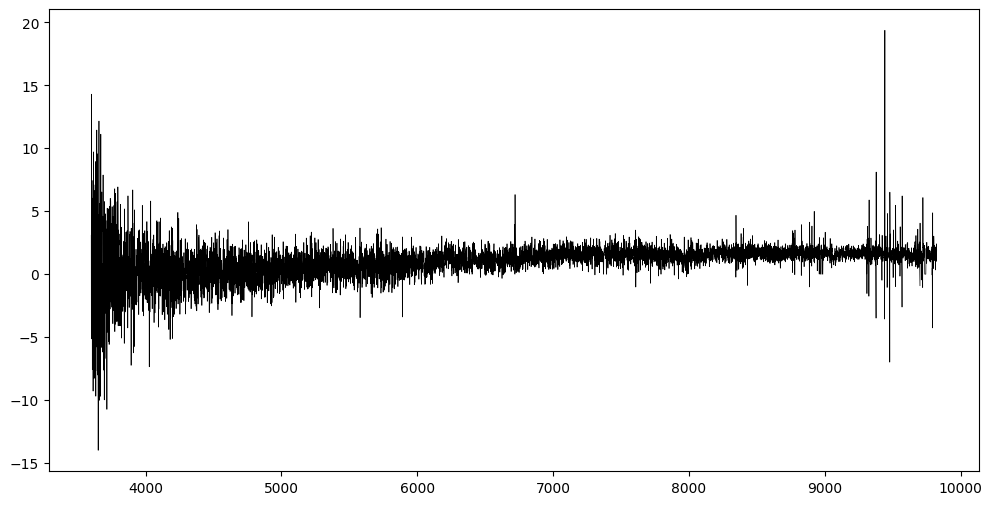

In [25]:
    lam, flux, ivar = combine_spec_arms_ivar(coadd_spec)
    err = 1 / np.sqrt(ivar)  # 1 sigma error

    plt.figure(idx, figsize=(12,6))
    plt.plot(lam, flux, color='black', lw=0.5)